# Building, training and deploying fastai models on SageMaker example

With Amazon SageMaker, you can package your own algorithms that can then be trained and deployed in the SageMaker environment. This notebook guides you through an example on how to build a custom container for SageMaker training and deployment using the popular [fast.ai](http://fast.ai) library.

By packaging an algorithm in a container, you can bring almost any code to the Amazon SageMaker environment, regardless of programming language, environment, framework, or dependencies. 

1. [Fast.ai on SageMaker example](#Fast.ai-on-SageMaker-example)
  1. [Permissions](#Permissions)
  1. [The example](#The-example)
  1. [The presentation](#The-presentation)
1. [Part 1: Packaging and Uploading your Algorithm for use with Amazon SageMaker](#Part-1:-Packaging-and-Uploading-your-Algorithm-for-use-with-Amazon-SageMaker)
    1. [An overview of Docker](#An-overview-of-Docker)
    1. [How Amazon SageMaker runs your Docker container](#How-Amazon-SageMaker-runs-your-Docker-container)
      1. [Running your container during training](#Running-your-container-during-training)
        1. [The input](#The-input)
        1. [The output](#The-output)
      1. [Running your container during hosting](#Running-your-container-during-hosting)
    1. [The parts of the sample container](#The-parts-of-the-sample-container)
    1. [The Dockerfile](#The-Dockerfile)
    1. [Building and registering the container](#Building-and-registering-the-container)
  1. [Testing your algorithm on your local machine](#Testing-your-algorithm-on-your-local-machine)
  1. [Download the Shirts dataset](#Download-the-Shirts-dataset)
  1. [SageMaker Python SDK Local Training](#SageMaker-Python-SDK-Local-Training)
  1. [Fit, Deploy, Predict](#Fit,-Deploy,-Predict)
  1. [Making predictions using Python SDK](#Making-predictions-using-Python-SDK)
1. [Part 2: Training and Hosting your Algorithm in Amazon SageMaker](#Part-2:-Training-and-Hosting-your-Algorithm-in-Amazon-SageMaker)
  1. [Set up the environment](#Set-up-the-environment)
  1. [Create the session](#Create-the-session)
  1. [Upload the data for training](#Upload-the-data-for-training)
  1. [Training On SageMaker](#Training-on-SageMaker)
  1. [Optional cleanup](#Optional-cleanup)  
1. [Reference](#Reference)

_or_ I'm impatient, just [let me see the code](#The-Dockerfile)!


## Permissions

Running this notebook requires permissions in addition to the normal `SageMakerFullAccess` permissions. This is because it creates new repositories in Amazon ECR. The easiest way to add these permissions is simply to add the managed policy `AmazonEC2ContainerRegistryFullAccess` to the role that you used to start your notebook instance. There's no need to restart your notebook instance when you do this, the new permissions will be available immediately.

## The example

In this example we show how to package a fastai container with an example application using a custom data set with a set of heavy metal t-shirts and sports shirts. By extending the SageMaker Fast.ai container we can utilize the existing training and hosting solution made to work on SageMaker found [here](https://github.com/mattmcclean/sagemaker-fastai-container). By comparison, if one were to build their own custom framework container from scratch, they would need to implement a training and hosting solution in order to use SageMaker. Here is an example showing [how to create a SageMaker TensorFlow container from scratch](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/tensorflow_bring_your_own/tensorflow_bring_your_own.ipynb).

In this example, we use a GPU image to support training and a CPU image to support hosting. We require a GPU image for training as we will require access to the cuda libraries to accelerate training. For hosting we do not require a GPU which can be expensive so we will use the CPU only libraries of fastai and PyTorch.

If you're only using Amazon SageMaker for training or hosting, but not both, only the functionality used needs to be built into your container.

## The presentation

This presentation is divided into two parts: _building_ the container and _using_ the container.

# Part 1: Packaging and Uploading your Algorithm for use with Amazon SageMaker

### An overview of Docker

If you're familiar with Docker already, you can skip ahead to the next section.

For many data scientists, Docker containers are a new technology. But they are not difficult and can significantly simplify the deployment of your software packages. 

Docker provides a simple way to package arbitrary code into an _image_ that is totally self-contained. Once you have an image, you can use Docker to run a _container_ based on that image. Running a container is just like running a program on the machine except that the container creates a fully self-contained environment for the program to run. Containers are isolated from each other and from the host environment, so the way your program is set up is the way it runs, no matter where you run it.

Docker is more powerful than environment managers like conda or virtualenv because (a) it is completely language independent and (b) it comprises your whole operating environment, including startup commands, and environment variable.

A Docker container is like a virtual machine, but it is much lighter weight. For example, a program running in a container can start in less than a second and many containers can run simultaneously on the same physical or virtual machine instance.

Docker uses a simple file called a `Dockerfile` to specify how the image is assembled. An example is provided below. You can build your Docker images based on Docker images built by yourself or by others, which can simplify things quite a bit.

Docker has become very popular in programming and devops communities due to its flexibility and its well-defined specification of how code can be run in its containers. It is the underpinning of many services built in the past few years, such as [Amazon ECS].

Amazon SageMaker uses Docker to allow users to train and deploy arbitrary algorithms.

In Amazon SageMaker, Docker containers are invoked in a one way for training and another, slightly different, way for hosting. The following sections outline how to build containers for the SageMaker environment.

Some helpful links:

* [Docker home page](http://www.docker.com)
* [Getting started with Docker](https://docs.docker.com/get-started/)
* [Dockerfile reference](https://docs.docker.com/engine/reference/builder/)
* [`docker run` reference](https://docs.docker.com/engine/reference/run/)

[Amazon ECS]: https://aws.amazon.com/ecs/

### How Amazon SageMaker runs your Docker container

Because you can run the same image in training or hosting, Amazon SageMaker runs your container with the argument `train` or `serve`. How your container processes this argument depends on the container. All SageMaker deep learning framework containers already cover this requirement and will trigger your defined training algorithm and inference code.

* If you specify a program as an `ENTRYPOINT` in the Dockerfile, that program will be run at startup and its first argument will be `train` or `serve`. The program can then look at that argument and decide what to do. The original `ENTRYPOINT` specified within the SageMaker PyTorch is [here](https://github.com/aws/sagemaker-pytorch-container/blob/master/docker/0.4.0/final/Dockerfile.cpu#L18).

#### Running your container during training

The base Docker image is based on the [SageMaker PyTorch Container](https://github.com/aws/sagemaker-pytorch-container) image as fast.ai is built on top of PyTorch. It can be found at this public [Github repo](https://github.com/mattmcclean/sagemaker-fastai-container). We have two images, one for GPU based training and a CPU based image for model hosting.

Currently, our SageMaker fastai container utilizes [console_scripts](http://python-packaging.readthedocs.io/en/latest/command-line-scripts.html#the-console-scripts-entry-point) to make use of the `train` command issued at training time. The line that gets invoked during `train` is defined within the setup.py file inside [SageMaker Containers](https://github.com/aws/sagemaker-containers/blob/master/setup.py#L48), our common SageMaker deep learning container framework. When this command is run, it will invoke the [trainer class](https://github.com/aws/sagemaker-containers/blob/master/src/sagemaker_containers/cli/train.py) to run, which will finally invoke our [fastai container code](https://github.com/mattmcclean/sagemaker-fastai-container/blob/master/src/sagemaker_pytorch_container/training.py) to run your Python file.

A number of files are laid out for your use, under the `/opt/ml` directory:

    /opt/ml
    ├── input
    │   ├── config
    │   │   ├── hyperparameters.json
    │   │   └── resourceConfig.json
    │   └── data
    │       └── <channel_name>
    │           └── <input data>
    ├── model
    │   └── <model files>
    └── output
        └── failure

##### The input

* `/opt/ml/input/config` contains information to control how your program runs. `hyperparameters.json` is a JSON-formatted dictionary of hyperparameter names to values. These values are always strings, so you may need to convert them. `resourceConfig.json` is a JSON-formatted file that describes the network layout used for distributed training.
* `/opt/ml/input/data/<channel_name>/` (for File mode) contains the input data for that channel. The channels are created based on the call to CreateTrainingJob but it's generally important that channels match algorithm expectations. The files for each channel are copied from S3 to this directory, preserving the tree structure indicated by the S3 key structure. 
* `/opt/ml/input/data/<channel_name>_<epoch_number>` (for Pipe mode) is the pipe for a given epoch. Epochs start at zero and go up by one each time you read them. There is no limit to the number of epochs that you can run, but you must close each pipe before reading the next epoch.

##### The output

* `/opt/ml/model/` is the directory where you write the model that your algorithm generates. Your model can be in any format that you want. It can be a single file or a whole directory tree. SageMaker packages any files in this directory into a compressed tar archive file. This file is made available at the S3 location returned in the `DescribeTrainingJob` result.
* `/opt/ml/output` is a directory where the algorithm can write a file `failure` that describes why the job failed. The contents of this file are returned in the `FailureReason` field of the `DescribeTrainingJob` result. For jobs that succeed, there is no reason to write this file as it is ignored.

#### Running your container during hosting

Hosting has a very different model than training because hosting is reponding to inference requests that come in via HTTP. Currently, the SageMaker PyTorch containers [uses](https://github.com/aws/sagemaker-pytorch-container/blob/master/src/sagemaker_pytorch_container/serving.py#L103) our [recommended Python serving stack](https://github.com/aws/sagemaker-containers/blob/master/src/sagemaker_containers/_server.py#L44) to provide robust and scalable serving of inference requests:

![Request serving stack](img/stack.png)

Amazon SageMaker uses two URLs in the container:

* `/ping` receives `GET` requests from the infrastructure. Your program returns 200 if the container is up and accepting requests.
* `/invocations` is the endpoint that receives client inference `POST` requests. The format of the request and the response is up to the algorithm. If the client supplied `ContentType` and `Accept` headers, these are passed in as well. 

The container has the model files in the same place that they were written to during training:
    
    /opt/ml
    └── model
        └── <model files>



### The parts of the sample container

The root directory has all the components you need to extend the SageMaker fast.ai container to use as an sample algorithm:

    .
    ├── Dockerfile
    ├── build_and_push.sh
    └── src
        ├── shirts.py

Let's discuss each of these in turn:

* __`Dockerfile`__ describes how to build your Docker container image. More details are provided below.
* __`build_and_push.sh`__ is a script that uses the Dockerfile to build your container GPU and CPU images and then push them to ECR. 
* __`src`__ is the directory which contains our user code to be invoked.

In this simple application, we install only one file in the container based on [Lesson 1](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1.ipynb) of the fast.ai MOOC course. You may only need that many, but if you have many supporting routines, you may wish to install more.

The files that we put in the container are:

* __`shirts.py`__ is the program based a custom image classification data set between photos of either heavy metal t-shirts or sports shirts that implements our training algorithm and handles loading our model for inferences.

### The Dockerfile

The Dockerfile describes the image that we want to build. You can think of it as describing the complete operating system installation of the system that you want to run. A Docker container running is quite a bit lighter than a full operating system, however, because it takes advantage of Linux on the host machine for the basic operations. 

We start from the [SageMaker fast.ai image](https://hub.docker.com/r/mattmcclean/sagemaker-fastai/) as the base image. This contains the PyTorch and fastai binaries as well as the SageMaker specific libraries explained earlier. The base image is an DockerHub image with the following pattern.

`{account}/sagemaker-fastai:{framework_version}-{processor_type}-{python_version}`

Here is an explanation of each field.
* __`account`__ - The DockerHub account to pull the base image from. Currently it is `mattmcclean`.
* __`framework_version`__ - The version of the fastai library. Currently is `1.0`
* __`processor_type`__ - CPU or GPU. We pass this as a Docker build arguement depending on the kind of image we want. Defaults to `gpu`.
* __`python_version`__ - The supported version of Python. Currently default is `py37`

So the SageMaker fast.ai DockerHub image would be:
`mattmcclean/sagemaker-fastai:1.0-gpu-py37`

```
docker pull mattmcclean/sagemaker-fastai:1.0-gpu-py37
docker pull mattmcclean/sagemaker-fastai:1.0-cpu-py37
```

In [11]:
%%bash
docker pull mattmcclean/sagemaker-fastai:1.0-gpu-py37
docker tag mattmcclean/sagemaker-fastai:1.0-gpu-py37 sagemaker-fastai:1.0-gpu-py37

1.0-gpu-py37: Pulling from mattmcclean/sagemaker-fastai
Digest: sha256:ef4b7563021b26b37d44a5985a8a552da232309625e218af3fe0e54107f956ac
Status: Image is up to date for mattmcclean/sagemaker-fastai:1.0-gpu-py37


You can also build your own base Docker image by performing the following steps:
1. Clone the Github repo with the command:

    `
    git clone https://github.com/mattmcclean/sagemaker-fastai-container
    `
   
   
2. Build the GPU and CPU Docker base images and push to your own ECR respository with the commands:
    
    `
    cd sagemaker-fastai-container
    ./build_and_push.sh
    `


## Testing your algorithm on your local machine

When you're packaging your first algorithm to use with Amazon SageMaker, you probably want to test it yourself to make sure it's working correctly. We use the [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) to test both locally and on SageMaker. For more examples with the SageMaker Python SDK, see [Amazon SageMaker Examples](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/sagemaker-python-sdk). In order to test our algorithm, we need our dataset.

In [12]:
%%bash
pushd utils
./setup.sh

~/SageMaker/sagemaker-fastai-example/utils ~/SageMaker/sagemaker-fastai-example
nvidia-docker2 already installed. updating default docker config
SageMaker instance routing for Docker is ok. We are good to go!


## Download the Shirts dataset
We will be utilizing a custom data set with a mixture of metal and sport shirts for training.

In [1]:
%mkdir -p data/shirts
!wget https://s3-eu-west-1.amazonaws.com/sagemaker-934676248949-eu-west-1/data/shirts_imgs.tar.gz
!tar zxf shirts_imgs.tar.gz -C data/shirts
!rm shirts_imgs.tar.gz

--2018-11-19 07:16:04--  https://s3-eu-west-1.amazonaws.com/sagemaker-934676248949-eu-west-1/data/shirts_imgs.tar.gz
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.104.82
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.104.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221495367 (211M) [application/x-tar]
Saving to: ‘shirts_imgs.tar.gz’

shirts_imgs.tar.gz  100%[===================>] 211.23M  10.6MB/s    in 23s     

2018-11-19 07:16:28 (9.07 MB/s) - ‘shirts_imgs.tar.gz’ saved [221495367/221495367]



In [1]:
import os
DATA_PATH=f'{os.getcwd()}/data/shirts'

In [2]:
%ls {DATA_PATH}

metal/  models/  sport/


## SageMaker Python SDK Local Training
To represent our training, we use the Estimator class, which needs to be configured in five steps. 
1. IAM role - our AWS execution role
2. train_instance_count - number of instances to use for training.
3. train_instance_type - type of instance to use for training. For training locally, we specify `local` or `local_gpu`.
4. image_name - our custom Fast.ai Docker image we created.
5. hyperparameters - hyperparameters we want to pass.

Let's start with setting up our IAM role. We make use of a helper function within the Python SDK. This function throw an exception if run outside of a SageMaker notebook instance, as it gets metadata from the notebook instance. If running outside, you must provide an IAM role with proper access stated above in [Permissions](#Permissions).

In [3]:
from sagemaker import get_execution_role

role = get_execution_role()

## Fit, Deploy, Predict

Now that the rest of our estimator is configured, we can call `fit()` with the path to our local Shirts dataset prefixed with `file://`. This invokes our fast.ai container with 'train' and passes in our hyperparameters and other metadata as json files in /opt/ml/input/config within the container to our program entry point defined in the Dockerfile.

After our training has succeeded, our training algorithm outputs our trained model within the /opt/ml/model directory, which is used to handle predictions.

We can then call `deploy()` with an instance_count and instance_type, which is 1 and `local`. This invokes our fast.ai container with 'serve', which setups our container to handle prediction requests as defined [here](https://github.com/aws/sagemaker-pytorch-container/blob/master/src/sagemaker_pytorch_container/serving.py#L103). What is returned is a predictor, which is used to make inferences against our trained model.

After our prediction, we can delete our endpoint.

We recommend testing and training your training algorithm locally first, as it provides quicker iterations and better debuggability.

In [4]:
base_image_name = 'sagemaker-fastai'
SRC_PATH = f'{os.getcwd()}/src/shirts'

In [5]:
import os
import subprocess

instance_type = 'local'
image_name = f'{base_image_name}:1.0-cpu-py37'

if subprocess.call('nvidia-smi') == 0:
    ## Set type to GPU if one is present
    instance_type = 'local_gpu'
    image_name = f'{base_image_name}:1.0-gpu-py37'
    
print("Instance type = " + instance_type)
print("Image = " + image_name)

Instance type = local_gpu
Image = sagemaker-fastai:1.0-gpu-py37


In [6]:
from sagemaker.local import local_session
# Create local session
sagemaker_session = local_session.LocalSession()
sagemaker_session.config = {'local': {'local_code': True }}

In [7]:
from sagemaker.pytorch import PyTorch

hyperparameters = {'epochs': 4, 'batch-size': 64}

estimator = PyTorch(entry_point='shirts.py',
                    source_dir=SRC_PATH,
                    role=role,
                    train_instance_count=1,
                    train_instance_type=instance_type,
                    image_name=f'698042698196.dkr.ecr.us-west-2.amazonaws.com/sagemaker-fastai:1.0-gpu-py37',
                    sagemaker_session=sagemaker_session,
                    hyperparameters=hyperparameters)

estimator.fit(f'file://{DATA_PATH}')

INFO:sagemaker:Creating training-job with name: sagemaker-fastai-2018-11-19-07-59-51-380


Creating tmptx6p8j7k_algo-1-8O455_1_f1bad98741c5 ... 
Attaching to tmptx6p8j7k_algo-1-8O455_1_d6bfec9f2f582mdone
algo-1-8O455_1_d6bfec9f2f58 | 2018-11-19 07:59:53,372 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
algo-1-8O455_1_d6bfec9f2f58 | 2018-11-19 07:59:53,372 sagemaker-containers INFO     Failed to parse hyperparameter sagemaker_submit_directory value /opt/ml/code to Json.
algo-1-8O455_1_d6bfec9f2f58 | Returning the value itself
algo-1-8O455_1_d6bfec9f2f58 | 2018-11-19 07:59:53,394 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
algo-1-8O455_1_d6bfec9f2f58 | 2018-11-19 07:59:53,397 sagemaker_pytorch_container.training INFO     Invoking user training script.
algo-1-8O455_1_d6bfec9f2f58 | 2018-11-19 07:59:53,399 sagemaker-containers INFO     Installing module with the following command:
algo-1-8O455_1_d6bfec9f2f58 | /usr/local/bin/python -m pip install -vvv -U . 
algo-1-8O455_1_d6bfec9f2f58 | Created t

## Making predictions using Python SDK

To make predictions, we will use a few images, from the test loader, converted into a json format to send as an inference request.

We will do predictions using a different Docker image that is CPU only rather than GPU based that was used for training.

The reponse will be tensors containing the probabilities of each image belonging to one of the 2 classes. Based on the highest probability we will map that index to the corresponding class in our output. 

In [8]:
import os, random
from PIL import Image

In [9]:
from sagemaker.predictor import RealTimePredictor, json_deserializer

class ImagePredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(endpoint_name, sagemaker_session=sagemaker_session, serializer=None, 
                                            deserializer=json_deserializer, content_type='image/jpeg')

In [13]:
model = estimator.create_model()
model.predictor_cls=ImagePredictor

In [ ]:
predictor = model.deploy(1, 'local')

In [15]:
from PIL import Image
import requests
from io import BytesIO

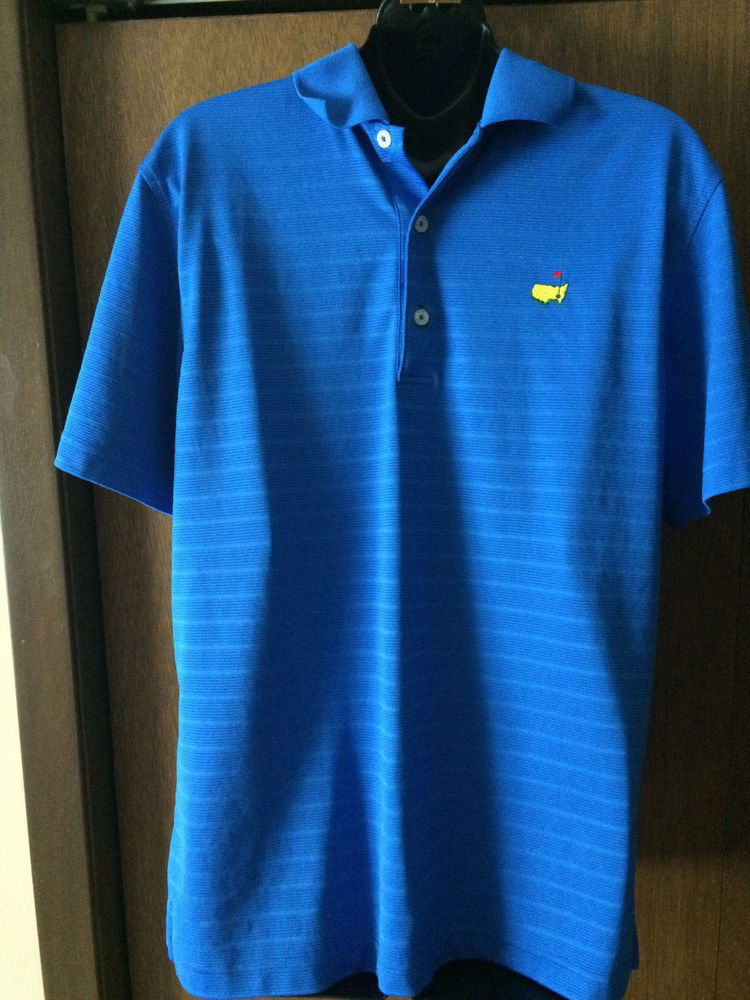

In [16]:
# Motorhead T-Shirt
#url = 'https://images.backstreetmerch.com/images/products/bands/clothing/mthd/bsi_mthd281.jpg'
# Judas Priest T-Shirt
#url = 'https://thumbs2.ebaystatic.com/d/l225/m/m7Lc1qRuFN3oFIlQla5V0IA.jpg'
# Australia Rugby T-Shirt
#url = 'https://www.lovell-rugby.co.uk/products/products_580x387/40378.jpg'
# Chicago Bulls top
#url = 'https://i.ebayimg.com/images/g/qc0AAOSwBahVN~qm/s-l300.jpg'
# Masters Golf Shirt
url = 'https://s-media-cache-ak0.pinimg.com/originals/29/6a/15/296a15200e7dd3ed08e12d9052ea4f97.jpg'
img_bytes = requests.get(url).content
img = Image.open(BytesIO(img_bytes))
img

In [17]:
response = predictor.predict(img_bytes)
response

{'class': 'metal', 'confidence': 0.7310577630996704}

In [18]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint with name: sagemaker-fastai-2018-11-19-07-59-51-380


# Part 2: Training and Hosting your Algorithm in Amazon SageMaker
Once you have your container packaged, you can use it to train and serve models. Let's do that with the algorithm we made above.

## Set up the environment
Here we specify the bucket to use and the role that is used for working with SageMaker.

In [19]:
# S3 prefix
prefix = 'DEMO-shirt-classifier'

## Create the session

The session remembers our connection parameters to SageMaker. We use it to perform all of our SageMaker operations.

In [20]:
import sagemaker as sage

sess = sage.Session()

## Upload the data for training

We will use the tools provided by the SageMaker Python SDK to upload the data to a default bucket.

In [ ]:
data_location = sess.upload_data(DATA_PATH, key_prefix=prefix)

In [ ]:
data_location

In [22]:
# run if data already uploaded
# data_location = 's3://' + sess.default_bucket() + '/' + prefix

## Training on SageMaker
Training a model on SageMaker with the Python SDK is done in a way that is similar to the way we trained it locally. This is done by changing our train_instance_type from `local` to one of our [supported EC2 instance types](https://aws.amazon.com/sagemaker/pricing/instance-types/).

In addition, we must now specify the ECR image URL, which we just pushed above.

Finally, our local training dataset has to be in Amazon S3 and the S3 URL to our dataset is passed into the `fit()` call.

Let's first fetch our ECR image url that corresponds to the image we just built and pushed.

In [23]:
import boto3

client = boto3.client('sts')
account = client.get_caller_identity()['Account']

my_session = boto3.session.Session()
region = my_session.region_name

algorithm_name = base_image_name
arch = 'gpu'

ecr_image = f'{account}.dkr.ecr.{region}.amazonaws.com/{algorithm_name}:1.0-{arch}-py37'

print(f'Using ECR image for training: {ecr_image}')

Using ECR image for training: 698042698196.dkr.ecr.us-west-2.amazonaws.com/sagemaker-fastai:1.0-gpu-py37


In [25]:
from sagemaker.estimator import Estimator

hyperparameters = {'epochs': 4, 'batch-size': 64}

instance_type_train = 'ml.p3.2xlarge'

estimator = PyTorch(entry_point='shirts.py',
                    source_dir=SRC_PATH,
                    role=role,
                    train_instance_count=1,
                    train_instance_type=instance_type_train,
                    image_name=ecr_image,
                    hyperparameters=hyperparameters)

estimator.fit(data_location)

INFO:sagemaker:Creating training-job with name: sagemaker-fastai-2018-11-19-08-06-14-296


2018-11-19 08:06:15 Starting - Starting the training job...
2018-11-19 08:06:16 Starting - Launching requested ML instances......
2018-11-19 08:07:21 Starting - Preparing the instances for training...
2018-11-19 08:08:01 Downloading - Downloading input data...
2018-11-19 08:08:18 Training - Downloading the training image......
2018-11-19 08:09:35 Training - Training image download completed. Training in progress.
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2018-11-19 08:09:36,265 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2018-11-19 08:09:36,286 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2018-11-19 08:09:37,697 sagemaker_pytorch_container.training INFO     Invoking user training script.
2018-11-19 08:09:37,963 sagemaker-containers INFO     Installing module with the following command:
/usr/local/bin/python -m pip install -vvv -U . 


In [ ]:
instance_type_deploy = 'ml.m5.xlarge'
arch = 'cpu'
ecr_image = f'{account}.dkr.ecr.{region}.amazonaws.com/{algorithm_name}:1.0-{arch}-py37'
print(f'Using ECR image for inference: {ecr_image}')

model = estimator.create_model()
model.predictor_cls=ImagePredictor
predictor = model.deploy(1, instance_type_deploy)

INFO:sagemaker:Creating model with name: sagemaker-fastai-2018-11-19-08-06-14-296


Using ECR image for inference: 698042698196.dkr.ecr.us-west-2.amazonaws.com/sagemaker-fastai:1.0-cpu-py37


INFO:sagemaker:Creating endpoint with name sagemaker-fastai-2018-11-19-08-06-14-296


----------------------------------

In [ ]:
# use on existing endpoint
#endpoint_name = ''
#predictor = ImagePredictor(endpoint=endpoint_name, sagemaker_session=my_session)

In [ ]:
from PIL import Image
import requests
from io import BytesIO

In [ ]:
# Motorhead T-Shirt
url = 'https://images.backstreetmerch.com/images/products/bands/clothing/mthd/bsi_mthd281.jpg'
# Judas Priest T-Shirt
#url = 'https://thumbs2.ebaystatic.com/d/l225/m/m7Lc1qRuFN3oFIlQla5V0IA.jpg'
# Australia Rugby T-Shirt
#url = 'https://www.lovell-rugby.co.uk/products/products_580x387/40378.jpg'
# Chicago Bulls top
#url = 'https://i.ebayimg.com/images/g/qc0AAOSwBahVN~qm/s-l300.jpg'
# Masters Golf Shirt
#url = 'https://s-media-cache-ak0.pinimg.com/originals/29/6a/15/296a15200e7dd3ed08e12d9052ea4f97.jpg'
img_bytes = requests.get(url).content
img = Image.open(BytesIO(img_bytes))
img

In [ ]:
response = predictor.predict(img_bytes)
response

## Optional cleanup
When you're done with the endpoint, you should clean it up.

All of the training jobs, models and endpoints we created can be viewed through the SageMaker console of your AWS account.

In [ ]:
predictor.delete_endpoint()

# Reference
- [How Amazon SageMaker interacts with your Docker container for training](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo.html)
- [How Amazon SageMaker interacts with your Docker container for inference](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-inference-code.html)
- [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk)
- [Dockerfile](https://docs.docker.com/engine/reference/builder/)
- [PyTorch extending container example](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/pytorch_extending_our_containers/pytorch_extending_our_containers.ipynb)
- [scikit-bring-your-own example](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/scikit_bring_your_own/scikit_bring_your_own.ipynb)
- [SageMaker fast.ai container](https://github.com/mattmcclean/sagemaker-fastai-container)
- [SageMaker fast.ai example](https://github.com/mattmcclean/sagemaker-fastai-example)
- [SageMaker PyTorch container](https://github.com/aws/sagemaker-pytorch-container)